Extract Data from File

In [2]:
!pip install mysql-connector-python
!pip install pymysql
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from dotenv import load_dotenv
import os

In [4]:
load_dotenv()
HOST = os.getenv("HOST")
PORT = int(os.getenv("PORT", "3306"))
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
DB = os.getenv("NAME")
CA_PEM = os.getenv("CA_PEM")
if not all([HOST, PORT, USER, PASSWORD, DB, CA_PEM]):
    raise SystemExit("Missing env vars. Set HOST, PORT, USER, PASSWORD, DB, CA_PEM in .env")

In [6]:
connection = pymysql.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database= DB,
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor,
        ssl={'ssl_disabled': False}  # Enable SSL for Aiven
    )

cursor = connection.cursor()
print("Database connected successfully!")

Database connected successfully!


In [7]:
cursor.execute('show tables;')
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table)

Tables in the database:
{'Tables_in_defaultdb': 'coffee_data'}
{'Tables_in_defaultdb': 'coffee_export'}
{'Tables_in_defaultdb': 'coffee_long'}
{'Tables_in_defaultdb': 'coffee_trade'}
{'Tables_in_defaultdb': 'production'}
{'Tables_in_defaultdb': 'weather'}


## Extract Data from All Tables

In [21]:
table_names = [table['Tables_in_defaultdb'] for table in tables]
dataframes = {}

for table_name in table_names:
    query = f"SELECT * FROM {table_name}"
    # Fetch data using cursor and then create DataFrame to avoid the warning
    cursor.execute(query)
    data = cursor.fetchall()
    df = pd.DataFrame(data)

    # Check if the first row is a header and remove it if it is
    if not df.empty and list(df.iloc[0].values) == list(df.columns):
        df = df.iloc[1:].reset_index(drop=True)

    dataframes[f'df_{table_name}'] = df
    print(f"Extracted and cleaned data from '{table_name}' into 'df_{table_name}'")

# Assign the dataframes to individual variables as well for easier access
df_coffee_data = dataframes['df_coffee_data']
df_coffee_export = dataframes['df_coffee_export']
df_coffee_long = dataframes['df_coffee_long']
df_coffee_trade = dataframes['df_coffee_trade']
df_production = dataframes['df_production']
df_weather = dataframes['df_weather']

print("\nAll tables extracted and cleaned into DataFrames.")

Extracted and cleaned data from 'coffee_data' into 'df_coffee_data'
Extracted and cleaned data from 'coffee_export' into 'df_coffee_export'
Extracted and cleaned data from 'coffee_long' into 'df_coffee_long'
Extracted and cleaned data from 'coffee_trade' into 'df_coffee_trade'
Extracted and cleaned data from 'production' into 'df_production'
Extracted and cleaned data from 'weather' into 'df_weather'

All tables extracted and cleaned into DataFrames.


## Display Data from Each Table

## Clean missing values in df_coffee_data and df_coffee_export using time series methods

In [29]:
# Define a list of the dataframes to process
dataframes_to_clean = {
    'df_coffee_data': df_coffee_data,
    'df_coffee_export': df_coffee_export
}

# Iterate through each dataframe and apply interpolation to fill missing values
for name, df in dataframes_to_clean.items():
    print(f"Processing missing values for {name}...")
    # Check for missing values before cleaning
    print(f"Missing values in {name} before cleaning:\n{df.isnull().sum()}")

    # Apply interpolation. 'linear' is a common method for time series.
    # Ensure the DataFrame is sorted by the 'year' column if it exists, as interpolation depends on order.
    if 'year' in df.columns:
        df = df.sort_values(by='year').reset_index(drop=True)

    # Apply interpolation to all columns with numeric data types
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].interpolate(method='linear', limit_direction='both')
        # Handle non-numeric columns with missing values if necessary (e.g., forward fill or backward fill for categories/objects)
        elif df[col].isnull().any():
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    # Update the dataframe in the dictionary
    dataframes_to_clean[name] = df
    print(f"Missing values in {name} after interpolation:\n{df.isnull().sum()}")

# Update the original dataframes with the cleaned versions
df_coffee_data = dataframes_to_clean['df_coffee_data']
df_coffee_export = dataframes_to_clean['df_coffee_export']

print("\nMissing value imputation complete for specified dataframes.")

Processing missing values for df_coffee_data...
Missing values in df_coffee_data before cleaning:
year                       0
temperature                0
humidity                   0
rain                       0
area_thousand_ha           0
output_volumn_tons         1
export_volume_tons         2
export_value_usd           2
price_world_usd_per_ton    0
price_vn_usd_per_ton       2
dtype: int64
Missing values in df_coffee_data after interpolation:
year                       0
temperature                0
humidity                   0
rain                       0
area_thousand_ha           0
output_volumn_tons         0
export_volume_tons         0
export_value_usd           0
price_world_usd_per_ton    0
price_vn_usd_per_ton       0
dtype: int64
Processing missing values for df_coffee_export...
Missing values in df_coffee_export before cleaning:
id                          0
year                        0
export_value_million_usd    2
price_world_usd_per_ton     0
price_vn_usd_per_ton

/tmp/ipython-input-481302518.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


In [31]:
print("DataFrame: df_coffee_data")
display(df_coffee_data)
print("\nDataFrame: df_coffee_export")
display(df_coffee_export)
print("\nDataFrame: df_coffee_trade")
display(df_coffee_trade)
print("\nDataFrame: df_production")
display(df_production)
print("\nDataFrame: df_weather")
display(df_weather)

DataFrame: df_coffee_data


,year,temperature,humidity,rain,area_thousand_ha,output_volumn_tons,export_volume_tons,export_value_usd,price_world_usd_per_ton,price_vn_usd_per_ton
0,2005,22.61,81.33,2424.5,497.4,831000.00,1229000.00,1911000000.00,1114.68,1554.92
1,2006,23.04,81.08,2111.9,497.0,985300.00,1229000.00,1911000000.00,1489.86,1554.92
2,2007,22.92,81.08,2062.0,509.3,1251000.00,1229000.00,1911000000.00,1910.01,1554.92
3,2008,22.62,81.33,2329.3,530.9,1055811.00,1060000.00,2111000000.00,2319.18,1991.51
4,2009,22.79,82.50,1887.3,538.5,1057540.00,1183523.00,1730602417.00,1643.41,1462.24
5,2010,23.34,80.92,1890.0,554.8,1105700.00,1217868.00,1851357772.00,1735.72,1520.16
6,2011,22.91,80.08,1634.1,586.2,1276506.00,1257246.00,2752417389.00,2408.29,2189.25
7,2012,22.43,80.17,2457.7,623.0,1260463.00,1732156.00,3672809719.00,2267.30,2120.37
8,2013,22.44,80.25,2243.8,637.0,1326688.00,1300146.00,2717513154.00,2074.93,2090.16
9,2014,22.54,80.83,2207.5,641.2,1406469.00,1690564.00,3556887418.00,2213.86,2103.97



DataFrame: df_coffee_export


,id,year,export_value_million_usd,price_world_usd_per_ton,price_vn_usd_per_ton
0,1,2005,1911.00,1114.68,1554.92
1,2,2006,1911.00,1489.86,1554.92
2,3,2007,1911.00,1910.01,1554.92
3,4,2008,2111.00,2319.18,1991.51
4,5,2009,1730.60,1643.41,1462.24
5,6,2010,1851.36,1735.72,1520.16
6,7,2011,2752.42,2408.29,2189.25
7,8,2012,3672.81,2267.30,2120.37
8,9,2013,2717.51,2074.93,2090.16
9,10,2014,3556.89,2213.86,2103.97



DataFrame: df_coffee_trade


,id,country,year,reporter,trade_flow,product_code,product_description,partner_year,partner_name,trade_value,quantity,quantity_unit,note
0,1,China,2005,China,Import,090111,Coffee not roasted or decaffeinated,2005,Vietnam,7316.15,9931360.0,Kg,None
1,2,China,2006,China,Import,090111,Coffee not roasted or decaffeinated,2006,Vietnam,17963.10,14491600.0,Kg,None
2,3,China,2007,China,Import,090111,Coffee not roasted or decaffeinated,2007,Vietnam,24136.50,14927200.0,Kg,None
3,4,China,2008,China,Import,090111,Coffee not roasted or decaffeinated,2008,Vietnam,32498.80,15601200.0,Kg,None
4,5,China,2009,China,Import,090111,Coffee not roasted or decaffeinated,2009,Vietnam,27511.30,17130800.0,Kg,None
5,6,China,2010,China,Import,090111,Coffee not roasted or decaffeinated,2010,Vietnam,36029.30,23635700.0,Kg,None
6,7,China,2011,China,Import,090111,Coffee not roasted or decaffeinated,2011,Vietnam,74695.80,32518600.0,Kg,None
7,8,China,2012,China,Import,090111,Coffee not roasted or decaffeinated,2012,Vietnam,86702.80,39561000.0,Kg,None
8,9,China,2013,China,Import,090111,Coffee not roasted or decaffeinated,2013,Vietnam,57881.30,27299500.0,Kg,None
9,10,China,2014,China,Import,090111,Coffee not roasted or decaffeinated,2014,Vietnam,92056.30,46377100.0,Kg,None



DataFrame: df_production


,id,year,area_thousand_ha,output_tons,export_tons
0,1,2005,497.4,831000.00,1229000.00
1,2,2006,497.0,985300.00,1229000.00
2,3,2007,509.3,1251000.00,1229000.00
3,4,2008,530.9,1055811.00,1060000.00
4,5,2009,538.5,1057540.00,1183523.00
5,6,2010,554.8,1105700.00,1217868.00
6,7,2011,586.2,1276506.00,1257246.00
7,8,2012,623.0,1260463.00,1732156.00
8,9,2013,637.0,1326688.00,1300146.00
9,10,2014,641.2,1406469.00,1690564.00



DataFrame: df_weather


,id,year,temperature,humidity,rain
0,1,2005,22.61,81.33,2424.5
1,2,2006,23.04,81.08,2111.9
2,3,2007,22.92,81.08,2062.0
3,4,2008,22.62,81.33,2329.3
4,5,2009,22.79,82.50,1887.3
5,6,2010,23.34,80.92,1890.0
6,7,2011,22.91,80.08,1634.1
7,8,2012,22.43,80.17,2457.7
8,9,2013,22.44,80.25,2243.8
9,10,2014,22.54,80.83,2207.5


## Visualize Data

### Heatmap of weather and production

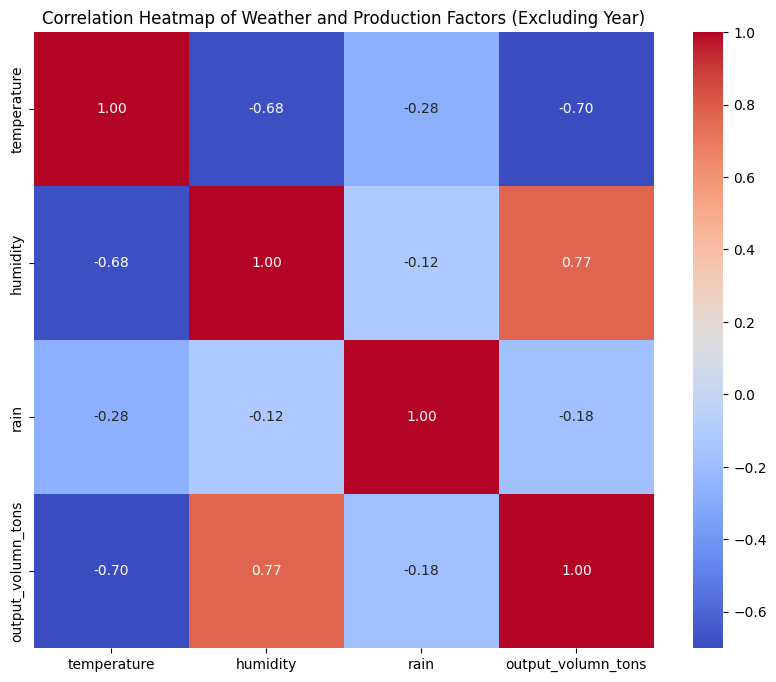

In [51]:
# Combine relevant columns from weather and production dataframes, excluding 'year'
weather_production_df = df_coffee_data[['temperature', 'humidity', 'rain', 'output_volumn_tons']]

# Calculate correlation matrix
correlation_matrix = weather_production_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Weather and Production Factors (Excluding Year)')
plt.show()

### Line plot of Vietnam vs. world coffee prices (2005-2024)

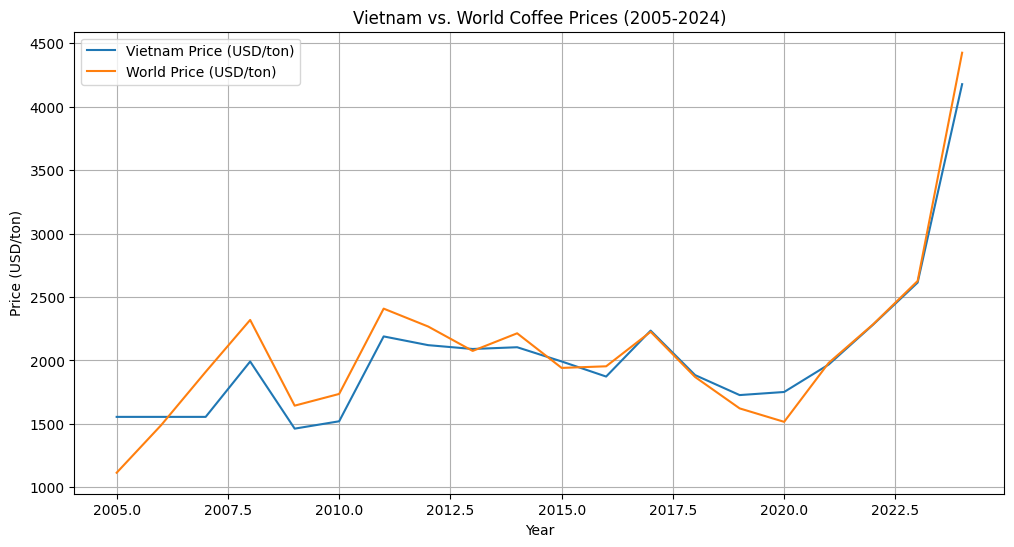

In [44]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee_data, x='year', y='price_vn_usd_per_ton', label='Vietnam Price (USD/ton)')
sns.lineplot(data=df_coffee_data, x='year', y='price_world_usd_per_ton', label='World Price (USD/ton)')
plt.title('Vietnam vs. World Coffee Prices (2005-2024)')
plt.xlabel('Year')
plt.ylabel('Price (USD/ton)')
plt.legend()
plt.grid(True)
plt.show()

### Line plots of Trade Value and Quantity from df_coffee_trade

### Line plot of Production Factors (Area, Output Volume, Export Volume)

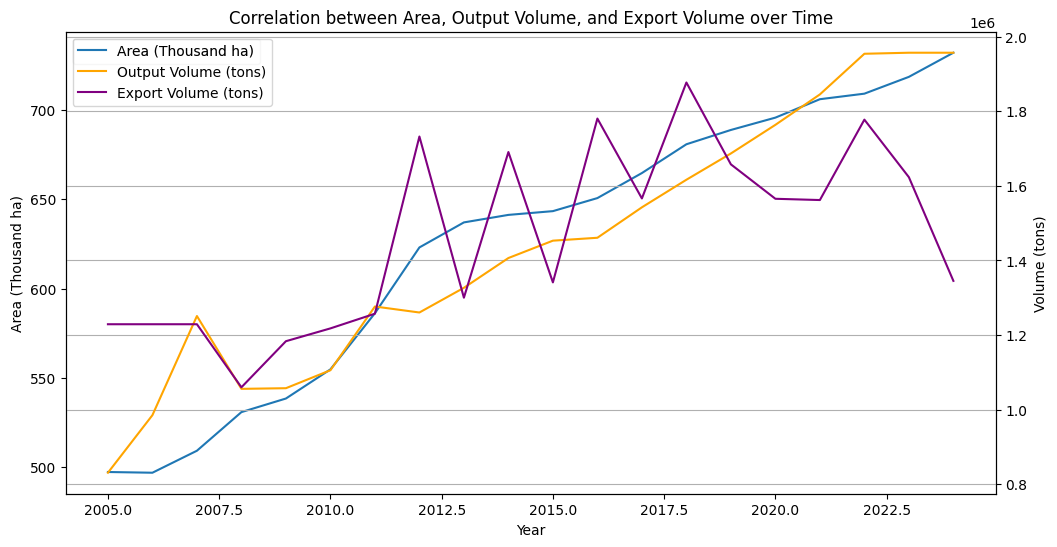

In [41]:
plt.figure(figsize=(12, 6))

# Plot Area
sns.lineplot(data=df_production, x='year', y='area_thousand_ha', label='Area (Thousand ha)')

# Plot Output Volume (scaling for better visualization if necessary)
# Let's check the range of values to decide if scaling is needed
# print(df_production[['area_thousand_ha', 'output_tons', 'export_tons']].max())
# Output volume and export volume are in tons, area is in thousand ha.
# They are on different scales, so let's plot them on separate y-axes or scale one of them.
# Using a secondary y-axis is better for showing the original scales.

# Create a secondary y-axis for output_tons and export_tons
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Output Volume
sns.lineplot(data=df_production, x='year', y='output_tons', label='Output Volume (tons)', color='orange', ax=ax2)

# Plot Export Volume
sns.lineplot(data=df_production, x='year', y='export_tons', label='Export Volume (tons)', color='purple', ax=ax2)


ax1.set_xlabel('Year')
ax1.set_ylabel('Area (Thousand ha)')
ax2.set_ylabel('Volume (tons)')
plt.title('Correlation between Area, Output Volume, and Export Volume over Time')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')


plt.grid(True)
plt.show()

### Line plots of Trade Value and Quantity for Top Export Markets

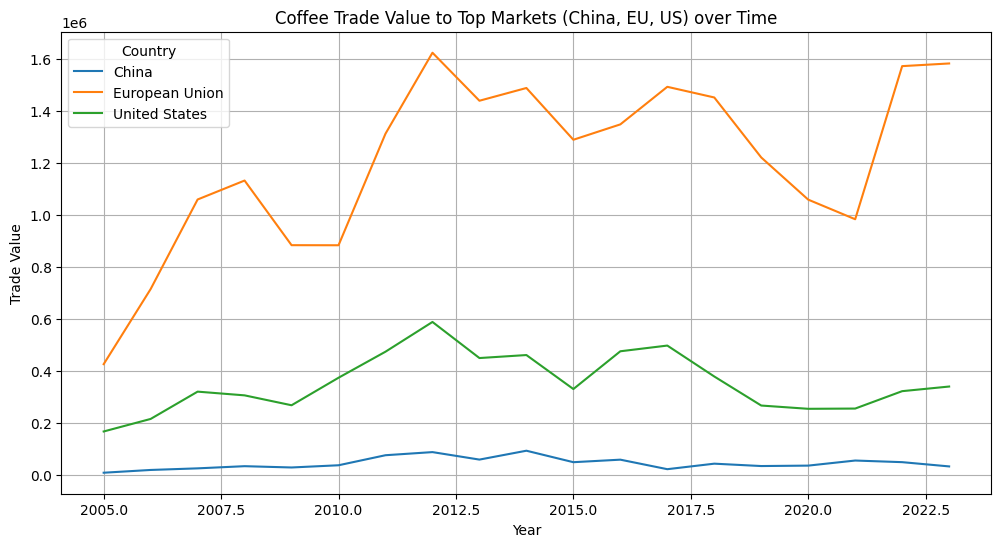

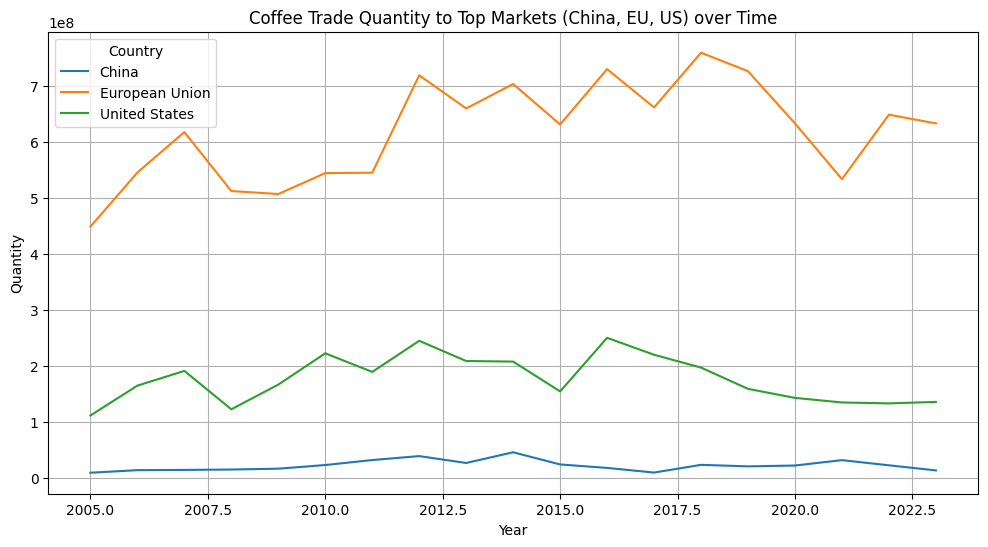

In [46]:
# Filter df_coffee_trade for the top export markets (China, European Union, United States)
top_markets_df = df_coffee_trade[df_coffee_trade['country'].isin(['China', 'European Union', 'United States'])].copy()

# Ensure year and relevant columns are numeric for plotting
top_markets_df['year'] = pd.to_numeric(top_markets_df['year'])
top_markets_df['trade_value'] = pd.to_numeric(top_markets_df['trade_value'])
top_markets_df['quantity'] = pd.to_numeric(top_markets_df['quantity'])


# Plot Trade Value for each market over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_markets_df, x='year', y='trade_value', hue='country')
plt.title('Coffee Trade Value to Top Markets (China, EU, US) over Time')
plt.xlabel('Year')
plt.ylabel('Trade Value')
plt.grid(True)
plt.legend(title='Country')
plt.show()

# Plot Quantity for each market over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_markets_df, x='year', y='quantity', hue='country')
plt.title('Coffee Trade Quantity to Top Markets (China, EU, US) over Time')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend(title='Country')
plt.show()

### Line plot of Export Value vs. Output Volume over Time

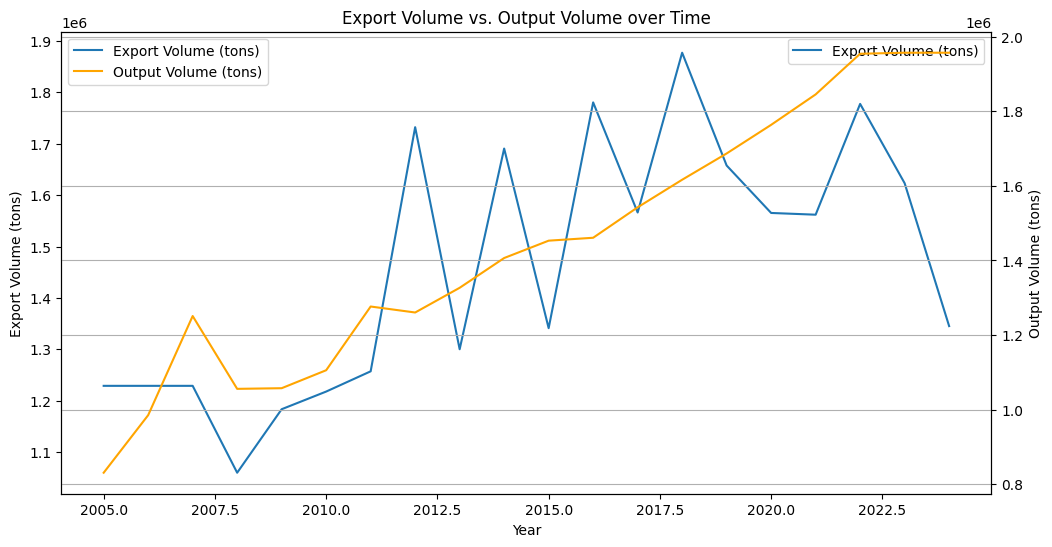

In [50]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_coffee_data, x='year', y='export_volume_tons', label='Export Volume (tons)')

# Create a secondary y-axis for output_volumn_tons as it's on a different scale
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(data=df_coffee_data, x='year', y='output_volumn_tons', label='Output Volume (tons)', color='orange', ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Export Volume (tons)')
ax2.set_ylabel('Output Volume (tons)')
plt.title('Export Volume vs. Output Volume over Time')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()